In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **UNET**

In [2]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out


In [3]:
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class CarvanaDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
              self.images = sorted([root_path+"/test/"+i for i in os.listdir(root_path+"/test/")])
              self.masks = sorted([root_path+"/test_masks/"+i for i in os.listdir(root_path+"/test_masks/")])
        else:
            self.images = sorted([root_path+"/test1/"+i for i in os.listdir(root_path+"/test1/")])
            self.masks = sorted([root_path+"/test1_masks/"+i for i in os.listdir(root_path+"/test1_masks/")])
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

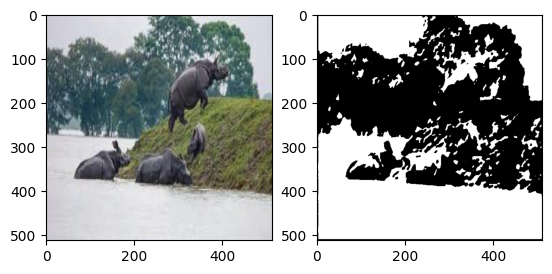

In [32]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2

def single_image_inference(image_pth, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    # Open the image
    img_pil = Image.open(image_pth)

    # Convert RGBA to RGB if image has 4 channels
    if img_pil.mode == 'RGBA':
        img_pil = img_pil.convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])

    img = transform(img_pil).float().to(device)
    img = img.unsqueeze(0)

    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0] = 0
    pred_mask[pred_mask > 0] = 1

    if pred_mask.shape[-1] == 1:
        pred_mask = torch.cat((pred_mask, pred_mask, pred_mask), dim=-1)  # Convert to 3 channels if single channel

    pred_mask_np = pred_mask.numpy()
    resized_mask = cv2.resize(pred_mask_np, (640, 640), interpolation=cv2.INTER_NEAREST)

    plt.imsave("/content/sample_data/1.jpg", resized_mask, cmap="gray")

    fig = plt.figure()
    for i in range(1, 3):
        fig.add_subplot(1, 2, i)
        if i == 1:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(pred_mask, cmap="gray")

    #plt.savefig("/content/runs/detect/1.jpg")
    plt.show()


if __name__ == "__main__":
    SINGLE_IMG_PATH = "/content/sample_data/rhino1.jpg"
    DATA_PATH = "/content/drive/MyDrive/project/unet_seg/data"
    MODEL_PATH = "/content/drive/MyDrive/project/unet_seg/model/unet_test1_15.pth"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    #pred_show_image_grid(DATA_PATH, MODEL_PATH, device)
    single_image_inference(SINGLE_IMG_PATH, MODEL_PATH, device)


# YOLO

In [6]:
  !pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 kB 6.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [7]:
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/project/yolov8/best.pt') #replace path to best.pt

In [30]:
# Pass an image path or a numpy array representing the image
results = model(SINGLE_IMG_PATH)  # Or results = model(image_array)
boxes = results[0].boxes

model.predict(SINGLE_IMG_PATH, save=True)


image 1/1 /content/sample_data/rhino1.jpg: 640x640 4 animals, 1609.0ms
Speed: 3.0ms preprocess, 1609.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/sample_data/rhino1.jpg: 640x640 4 animals, 1516.8ms
Speed: 2.6ms preprocess, 1516.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'animal', 1: 'person'}
 obb: None
 orig_img: array([[[214, 203, 205],
         [214, 203, 205],
         [214, 203, 205],
         ...,
         [225, 215, 215],
         [225, 215, 215],
         [225, 215, 215]],
 
        [[214, 203, 205],
         [214, 203, 205],
         [214, 203, 205],
         ...,
         [225, 215, 215],
         [225, 215, 215],
         [225, 215, 215]],
 
        [[214, 203, 205],
         [214, 203, 205],
         [214, 203, 205],
         ...,
         [225, 215, 215],
         [225, 215, 215],
         [225, 215, 215]],
 
        ...,
 
        [[204, 198, 199],
         [204, 198, 199],
         [204, 198, 199],
         ...,
         [210, 207, 209],
         [210, 207, 209],
         [210, 207, 209]],
 
        [[204, 198, 199],
         [204, 198, 199],
         [204, 198, 199],
         ...,
     

# **Combined Model**

In [34]:
 # Access the first bounding box in xyxy format
 # Access the first bounding box (modify index for others)
    # Unpack coordinates (top-left, bottom-right)

  # Import OpenCV for image processing

def check_corresponding_pixels(image1_path, image2_path, bbox, save_image=False, save_path="/content/sample_data/high.jpg"):
  """
  Checks the pixels in corresponding positions based on the bounding box in image1 and image2.

  Args:
      image1_path (str): Path to the first image.
      image2_path (str): Path to the second image.
      bbox (list): Bounding box coordinates in format [x_center, y_center, width, height].
      save_image (bool, optional): Flag to save the resulting image with highlighted pixels. Defaults to False.
      save_path (str, optional): Path to save the highlighted image. Defaults to None.

  Returns:
      list
  """

  # Load images
  image1 = cv2.imread(image1_path)
  image2 = cv2.imread(image2_path)

  # Check if images are loaded successfully
  if image1 is None or image2 is None:
    print("Error: Could not load images.")
    return

  # Extract bounding box coordinates
  x_center, y_center, width, height = bbox[0]
  x_min = int(max(0, x_center - width / 2))  # Ensure coordinates are within image bounds
  y_min = int(max(0, y_center - height / 2))
  x_max = int(min(image1.shape[1], x_center + width / 2))  # Ensure coordinates are within image bounds
  y_max = int(min(image1.shape[0], y_center + height / 2))

  # Check if bounding box is valid (within image1)
  if x_min >= x_max or y_min >= y_max:
    print("Warning: Bounding box is invalid or outside image1.")
    return

  top_left = [x_min, y_min]
  top_right = [x_max, y_min]
  bottom_right = [x_max, y_max]
  bottom_left = [x_min, y_max]

  corners = [bottom_left, bottom_right, top_left, top_right]
  num_corners_with_high_values = 0

  pixel_values = []
  for corner in [top_left, top_right, bottom_right, bottom_left]:
    x, y = corner
    if 0 <= y < image2.shape[0] and 0 <= x < image2.shape[1]:
      pixel_value = image2[y, x]
      pixel_values.append(pixel_value)  # Access pixel value at valid corner location

      if pixel_value[0] > 200 and pixel_value[1] > 200 and pixel_value[2] > 200:
        num_corners_with_high_values += 1
    else:
      pixel_values.append("Out of Bounds")  # Indicate out-of-bounds case (optional)

  # Print or store pixel values


  if num_corners_with_high_values >= 2:
    image1_copy = image1.copy()
    cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green rectangle



  # Display or save the images
  if save_image:
    if save_path is None:
      save_path = "highlighted_image.jpg"
    cv2.imwrite(save_path, image1_copy)
    print("Saved highlighted image to:", save_path)
  else:
    cv2.imwrite(save_path, image_with_boxes)
    print("Saved highlighted image to:", save_path)



  return num_corners_with_high_values

# Example usage
image1_path = SINGLE_IMG_PATH
image2_path = "/content/sample_data/1.jpg"  # Replace with your second image path

image1 = cv2.imread(image1_path)
image_with_boxes = image1.copy()

all_pixel_values = []

for box in boxes:
  # Get bounding box information (format: [x_center, y_center, width, height])
  bbox = box.xywh
  #print(bbox)
  values = check_corresponding_pixels(image1_path, image2_path, bbox)
  if values is not None:
      all_pixel_values.append(values)

print(all_pixel_values)

Saved highlighted image to: /content/sample_data/high.jpg
Saved highlighted image to: /content/sample_data/high.jpg
Saved highlighted image to: /content/sample_data/high.jpg
Saved highlighted image to: /content/sample_data/high.jpg
[1, 0, 4, 0]
